In [33]:
cd(@__DIR__)
include("setup.jl")
import Pkg; Pkg.activate(@__DIR__)
using Logging, DelimitedFiles, Random, LinearAlgebra, Statistics
using CairoMakie
using HiddenDynamicsInference
blues =  [colorant"#3E4756", colorant"#A2ACBD", colorant"#7493BC", colorant"#2271B2", colorant"#72AFF5", colorant"#EFFAFF"]
greens =  [colorant"#384B42", colorant"#9BB0A5", colorant"#659C82", colorant"#359B73", colorant"#ABD07A", colorant"#E8FFF3"]

  Activating project at `~/Research/HiddenDynamicsInference/examples`


In [34]:
# Parameters for the notebook
numflds = 3 # Total number of equations in the model 
numvars = 2 # Number of observed fields
data_window = 141:375 #Window to crop data to ~3 oscillations
# Amount of noise to add to the data
noise_level = 0
# Random seed for reproducibility
rng = MersenneTwister(1111)
# Tolerances for the ODE solutions
reltol = 1e-6
abstol = 1e-8
# Whether to run the sweeps. WARNING these can take hours
RUNSWEEPS = false

false

# Hidden Dynamics Inference - Lorenz
1. Start by simulating some noisy data and cropping to the training window

In [35]:
# Simulate test data
truep = vcat([-10.0, 10.0], [28.0, -1.0, -1.0], [-8/3, 1.0])
tspan = (0.0, 250.0)
function lorenz_odefun!(du, u, p, t)
    du[1] = 10.0 * (u[2] - u[1])
    du[2] = u[1] * (28.0 - u[3]) - u[2]
    du[3] = u[1] * u[2] - 8/3 * u[3]
end
prob = ODEProblem(lorenz_odefun!, [1.0, 1.0, 1.0], tspan)
truedata = solve(prob, Tsit5(), saveat = 0.5, abstol = 1e-14, reltol = 1e-14)
truep = [truedata[:, data_window[1]]; normalize(truep[1:2]); normalize(truep[3:5]); normalize(truep[6:7]); norm(truep[1:2]); norm(truep[3:5]); norm(truep[6:7])]

# add noise to the data
fulldata = truedata[1:numvars, :] + noise_level / 100 * std(truedata[1:numvars, :], dims = 2) .* randn(rng, numvars, size(truedata, 2))
data = fulldata[:, data_window]
t = truedata.t[data_window] .-  truedata.t[data_window[1]]
fulldata = fulldata[:, data_window[1]:end]
fullt = truedata.t[data_window[1]:end] .-  truedata.t[data_window[1]]

println("Data loss with true Lorenz: $(sum(abs2, data - truedata[1:numvars, data_window]) / (numvars * length(data_window)))")

Data loss with true Lorenz: 0.0


# 2/3. Optimization sweep 

In [36]:
if RUNSWEEPS
# Sweep parameters
reps = 50
sweep_lambdas = [0.005, 0.01] # Add additional lambdas here
degrees = [[1, 2, 2], ] # Add additional degree combinations e.g. linear cubic (1, 3) to the vector 

# Preallocate storage for the sweeps
params = Vector{Float64}[]
train_losses = Float64[]
train_delay_losses = Float64[]
test_delay_losses = Float64[]
degrees1 = Int64[]
degrees2 = Int64[]
degrees3 = Int64[]
lambdas = Float64[]

# Sweep 
disable_logging(Logging.Warn)
for degree in degrees
    HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(numflds, degree), t, data)
    for lambda = sweep_lambdas
        for rep = 1:reps
            push!(lambdas, lambda); push!(degrees1, degree[1]); push!(degrees2, degree[2]); push!(degrees3, degree[3])
            # Randomly initalize a suitable parameter vector for the problem 
            p0 = randinit(HDIprob)
            # Optimize the parameters
            optp, optval = HiddenDynamicsInference.optimize(HDIprob, p0, lambda = lambda, showprogress = false)
            # Center and scale the coefficients 
            center_coefficients!(HDIprob, optp, 3)
            std_scale_coefficients!(HDIprob, optp, 3)
            # map_coefficients(optp, HDIprob.pows, refpows)
            push!(params, optp)
            # Calculate the train loss
            train_loss = dataloss(HDIprob, optp, 1; verbose = false, reltol = reltol, abstol = abstol)
            push!(train_losses, train_loss)
            # Search for the limit cycle
            train_delay_loss, test_delay_loss, desc_str = find_limit_cycle(HDIprob, optp, fullt, verbose = false, fulldata, abstol = abstol)
            push!(train_delay_losses, train_delay_loss)
            push!(test_delay_losses,  test_delay_loss)
            print(stdout, "$(rep) - $(optval), "); flush(stdout)
        end
    end
end
HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(3, [2, 2, 2]), t, data)
else
HDIprob = PolynomialHiddenDynamicsInferenceProblem(powgenerate(3, [2, 2, 2]), t, data)
sweepcsv, sweepheader = readdlm("lorenz_3D_noise0_sweep_results.csv", '\t', header = true)
degrees1 = Int64.(sweepcsv[:, 1])
degrees2 = Int64.(sweepcsv[:, 2])
degrees3 = Int64.(sweepcsv[:, 3])
lambdas  = Float64.(sweepcsv[:, 4])
train_losses = Float64.(sweepcsv[:, 5])
validation_losses = Float64.(sweepcsv[:, 6])
train_delay_losses = Float64.(sweepcsv[:, 7])
test_delay_losses = Float64.(sweepcsv[:, 8])
parammat = sweepcsv[:, 9:end];
parammat[isnan.(parammat)] .= 0.0
params = Vector{Float64}.(collect(eachrow(parammat)));
nothing
end

# 4/5. Automatically filter models

In [37]:
# Only keep models with limit cycles and finite losses
# Set the good model threshold by fitting a Kernel Density Estimate
filtered_train_losses = train_losses[.!isnan.(train_losses) .& .!isinf.(train_losses)]
train_loss_thresh, kde_fit = calculate_KDEthresh(filtered_train_losses)
good_model_inds = findall((train_losses .< train_loss_thresh) .& (validation_losses .< 10));
println("Number of good models kept is $(length(good_model_inds))")

Number of good models kept is 3330


# 6-8. Model distance matrix

In [38]:
# Calculate the parameter matrix multiplying back by tau
cumsplits = [0; cumsum(HDIprob.splits)...]
coeffmat = hcat(params[good_model_inds]...)[numflds + 1:end, :] # crop the ICs 
for i = 1:numflds
    # Rescale by tau 
    coeffmat[cumsplits[i] + 1:cumsplits[i + 1], :] .*= coeffmat[end - numflds + i, :]' 
end
coeffmat = coeffmat[1:cumsplits[end], :]

# Compute distance matrix between all good models
Dcoeffs, coeffmat_symms, linear_transforms, best_symm = compute_model_distances(coeffmat, HDIprob.pows; numobs=numvars, signflip=true, permute=false)

# Cluster the distance matrix
result = hclust(Dcoeffs; linkage=:single, branchorder=:optimal);

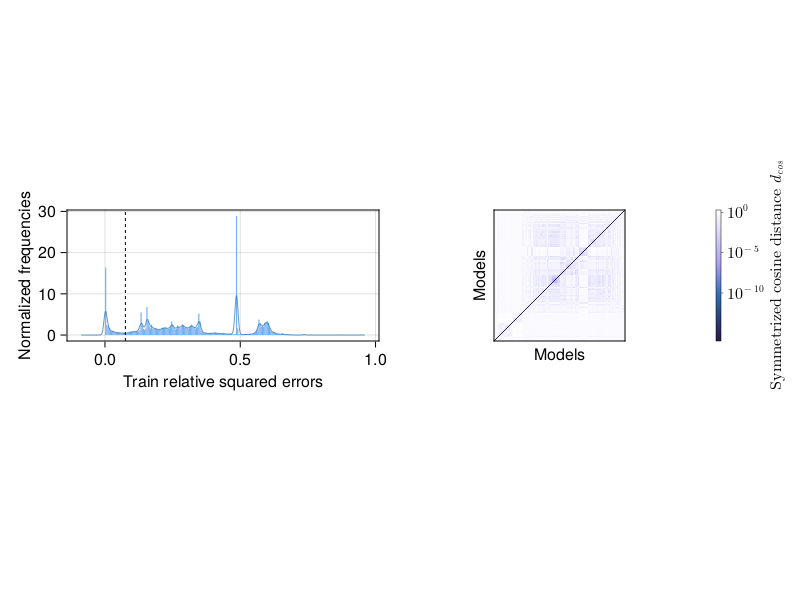

CairoMakie.Screen{IMAGE}


In [39]:
fig = Figure()
ax = Axis(fig[1, 1])
hist!(ax, filtered_train_losses, bins=200, normalization=:pdf, color=blues[5])
lines!(ax, kde_fit.x, kde_fit.density, color=(blues[4], 0.7), linewidth=1)
vlines!(ax, train_loss_thresh, color=:black, linestyle=:dash, linewidth=1)
ax.xlabel = "Train relative squared errors"
ax.ylabel = "Normalized frequencies"

ax = Axis(fig[1, 2], aspect=1)
hm = heatmap!(ax, log10.(Dcoeffs[result.order, result.order]), colormap=:devon)
Colorbar(fig[1, 3], hm, label=Makie.latexstring("Symmetrized cosine distance \$d_{cos}\$"), width=5, height=131, ticksize=2, spinewidth=0.5, tickwidth=0.5, ticks=([-10, -5, 0], [L"10^{-10}", L"10^{-5}", L"10^0"]))
hidedecorations!(ax, label = false)
ax.xlabel = "Models"; ax.ylabel = "Models"
colgap!(fig.layout, 1)
display(fig)

# 9 - 11. Model Clustering

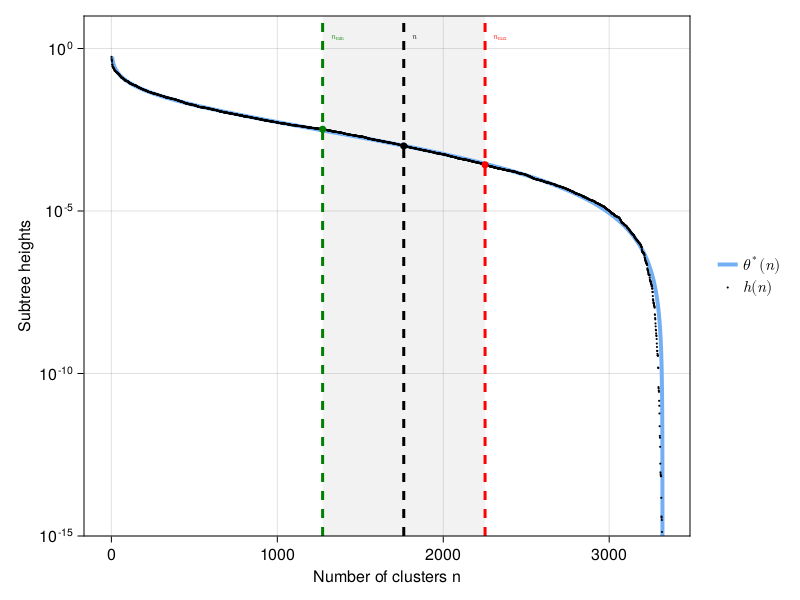

CairoMakie.Screen{IMAGE}


In [40]:
# Perform heirarchical clustering and inspect clusters at a range of cutoffs
rng = MersenneTwister(2222)
kmin, Dmin, kmax, Dmax, hierarchical_clustering, fit_height_curve = hierarchical_clustering_range(Dcoeffs; rng=rng)
kmid = floor(Int64, (kmin+kmax)/2)
Dmid = HiddenDynamicsInference.k_to_h(result, kmid)

# Plotting
fig = Figure()
ax = Axis(fig[1, 1], yscale=log10)
heights = reverse(result.heights); heights = heights[heights .> 0]
poly!(ax, Rect(kmin, 1e-18, kmax-kmin, 1e3), color = (:gray, 0.1))
lin = lines!(ax, fit_height_curve, heights; linewidth=4, color=blues[5])
sca = scatter!(ax, 1:length(heights), heights, color=:black, markersize=3)
scatter!(ax, kmin, Dmax, color="green", markersize=10)
scatter!(ax, kmid, Dmid, color=:black, markersize=10)
scatter!(ax, kmax, Dmin, color="red", markersize=10)
text!(ax, kmin+50, 3; text=L"n_\text{min}", fontsize=8, color="green", align=(:left, :top))
text!(ax, kmid+50, 3; text=L"n", fontsize=8, color=:black, align=(:left, :top))
text!(ax, kmax+50, 3; text=L"n_\text{max}", fontsize=8, color="red", align=(:left, :top))
vlines!(ax, kmin, linestyle=:dash, linewidth=3, color="green")
vlines!(ax, kmid, linestyle=:dash, linewidth=3, color=:black)
vlines!(ax, kmax, linestyle=:dash, linewidth=3, color="red")
ylims!(ax, 1e-15, 1e1)
ax.xlabel="Number of clusters n"
ax.ylabel="Subtree heights"
Legend(fig[1, 2], [lin, sca], [L"\theta^*(n)", L"h(n)"]; width=70, height=50, framevisible=false)
display(fig)

# 12-14. Model ranking

In [41]:
# Rank model terms using coefficient of variation at several different cutoffs
coeff_ranks, term_pos_counts = coeff_var_ranking(hierarchical_clustering, kmin, kmax; coeffmat_symms=coeffmat_symms, best_symm=best_symm)

214 / 3330


([25 25 … 29 29; 2 2 … 2 2; … ; 8 8 … 10 10; 13 13 … 14 14], [0.0 0.0 … 147.0 13.0; 313.0 667.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0])

In [42]:
# Average these rankings with the Kemeny-Young algorithm
aggr_rank, opt_X, obj_val = kemeny_young(coeff_ranks)
eqstrs = pow2strs(HDIprob.pows, ["x", "y", "z"])
for (i, trm) = enumerate(eqstrs[sortperm(aggr_rank)])
    println("Rank $(i) term -- " * trm)
end

Rank 1 term -- Eq.1: y
Rank 2 term -- Eq.1: x
Rank 3 term -- Eq.2: xz
Rank 4 term -- Eq.3: xy
Rank 5 term -- Eq.2: x
Rank 6 term -- Eq.3: z
Rank 7 term -- Eq.2: y
Rank 8 term -- Eq.3: 1
Rank 9 term -- Eq.2: yz
Rank 10 term -- Eq.3: yz
Rank 11 term -- Eq.1: y²
Rank 12 term -- Eq.3: x²
Rank 13 term -- Eq.1: xy
Rank 14 term -- Eq.3: z²
Rank 15 term -- Eq.2: y²
Rank 16 term -- Eq.3: y²
Rank 17 term -- Eq.2: z²
Rank 18 term -- Eq.1: xz
Rank 19 term -- Eq.2: x²
Rank 20 term -- Eq.3: xz
Rank 21 term -- Eq.1: yz
Rank 22 term -- Eq.2: xy
Rank 23 term -- Eq.1: z²
Rank 24 term -- Eq.1: x²
Rank 25 term -- Eq.2: 1
Rank 26 term -- Eq.2: z
Rank 27 term -- Eq.1: z
Rank 28 term -- Eq.3: y
Rank 29 term -- Eq.1: 1
Rank 30 term -- Eq.3: x
